In [1]:
# Imports
import numpy as np
from utils.load_npz import load_dataset
from utils.preprocess import preprocess_batch
import matplotlib.pyplot as plt
from config import Config

In [ ]:
# Load .npz
TASK = 'emotion'  # 'emotion' or 'intent'
dataset = load_dataset(task_type=TASK)

# Basic info
fs = int(dataset['sampling_rate'])
n_channels = int(dataset['X_train'].shape[1])
n_samples  = int(dataset['X_train'].shape[2])

if 'class_names' in dataset:
    class_names = list(dataset['class_names'])
elif 'label_map' in dataset:
    class_names = list(dataset['label_map'].keys())
else:
    class_names = sorted(list(np.unique(dataset['y_train'])))
n_classes = len(class_names)

print('fs:', fs, '| channels:', n_channels, '| samples:', n_samples)
print('classes:', n_classes, class_names)

[2025-08-27 09:57:56] Loading dataset from d:\Projects\emo_bci\data\intent_dataset_20250826_201559.npz
  -> Dataset loaded successfully
  -> Task: intent_detection
  -> Channels: ['F7', 'FT7', 'T7', 'F8', 'FT8', 'T8']
  -> Sampling rate: 250 Hz
  -> Trial duration: 10.0 s
  -> Train: 72 samples
  -> Val: 16 samples
  -> Test: 12 samples
  -> Data shape: (72, 6, 2500)
fs: 250 | channels: 6 | samples: 2500
classes: 4 [np.str_('baseline'), np.str_('jaw_clench'), np.str_('gaze_left'), np.str_('gaze_right')]


preprocessed: (72, 6, 2500) (16, 6, 2500) (12, 6, 2500)
sanity OK


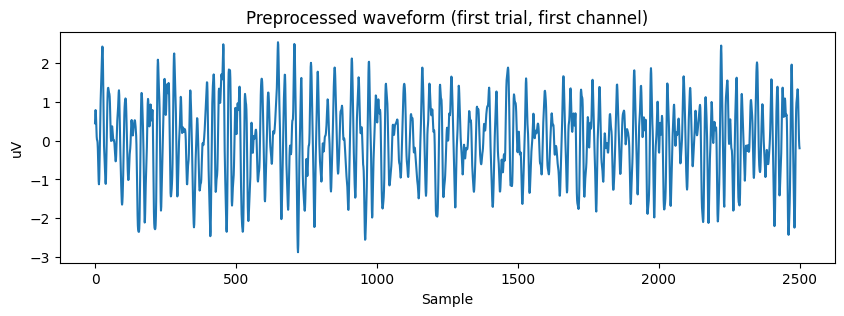

In [3]:
# Fixed params (independent of Config)
NOTCH_F0, NOTCH_Q = 50.0, 25.0
BAND = (1.0, 40.0)
ORDER = 4
MA_WINDOW = None
GAUSS_SIGMA = None
WAVELET = None          # e.g. {'name':'db4','level':None,'mode':'soft'}
ICA_N = None
ICA_REMOVE = None
DO_ZSCORE = True

# Run preprocess
X_time_train = preprocess_batch(
    dataset['X_train'], fs,
    notch_freq=NOTCH_F0, notch_q=NOTCH_Q,
    band=BAND, order=ORDER,
    ma_window=MA_WINDOW, gaussian_sigma=GAUSS_SIGMA,
    wavelet=WAVELET,
    ica_n=ICA_N, ica_remove_idx=ICA_REMOVE,
    do_zscore=DO_ZSCORE
)
X_time_val = preprocess_batch(
    dataset['X_val'], fs,
    notch_freq=NOTCH_F0, notch_q=NOTCH_Q,
    band=BAND, order=ORDER,
    ma_window=MA_WINDOW, gaussian_sigma=GAUSS_SIGMA,
    wavelet=WAVELET,
    ica_n=ICA_N, ica_remove_idx=ICA_REMOVE,
    do_zscore=DO_ZSCORE
)
X_time_test = preprocess_batch(
    dataset['X_test'], fs,
    notch_freq=NOTCH_F0, notch_q=NOTCH_Q,
    band=BAND, order=ORDER,
    ma_window=MA_WINDOW, gaussian_sigma=GAUSS_SIGMA,
    wavelet=WAVELET,
    ica_n=ICA_N, ica_remove_idx=ICA_REMOVE,
    do_zscore=DO_ZSCORE
)

print('preprocessed:', X_time_train.shape, X_time_val.shape, X_time_test.shape)

# Quick sanity
assert np.isfinite(X_time_train).all() and np.isfinite(X_time_val).all() and np.isfinite(X_time_test).all()
print('sanity OK')

# Optional preview
plt.figure(figsize=(10,3))
plt.plot(X_time_train[0,0])
plt.title('Preprocessed waveform (first trial, first channel)')
plt.xlabel('Sample'); plt.ylabel('uV'); plt.show()


In [4]:
# window spec by task
WIN_SEC = 2.0 if TASK == 'intent' else 10.0
HOP_SEC = 1.0  # recommended

# check expected window length
fs = int(dataset['sampling_rate'])
T_sec = X_time_train.shape[-1] / fs
assert abs(T_sec - WIN_SEC) < 1e-3 or T_sec > WIN_SEC, f'Expect {WIN_SEC} s or longer, got {T_sec:.3f} s'
print('Expected window:', WIN_SEC, 's | current:', T_sec, 's')


Expected window: 2.0 s | current: 10.0 s


In [5]:
import numpy as np

def sliding_window(X, y, fs, win_s, hop_s):
    # X: (N,C,Tlong), y: (N,)
    L = int(fs * win_s)
    S = int(fs * hop_s)
    Xw, Yw = [], []
    for n in range(X.shape[0]):
        T = X[n].shape[-1]
        if T < L: 
            continue
        for start in range(0, T - L + 1, S):
            Xw.append(X[n, :, start:start+L])
            Yw.append(int(y[n]))
    Xw = np.stack(Xw).astype(np.float32)
    Yw = np.array(Yw, dtype=int)
    return Xw, Yw

def maybe_window(X, y, fs, win_s, hop_s):
    L = int(fs * win_s)
    if X.shape[-1] == L:
        return X.astype(np.float32), y.astype(int)
    if X.shape[-1] > L:
        return sliding_window(X, y, fs, win_s, hop_s)
    raise ValueError(f'Window too short: need {L}, got {X.shape[-1]}')

# apply only if needed
X_time_train, y_train_new = maybe_window(X_time_train, dataset['y_train'], fs, WIN_SEC, HOP_SEC)
X_time_val,   y_val_new   = maybe_window(X_time_val,   dataset['y_val'],   fs, WIN_SEC, HOP_SEC)
X_time_test,  y_test_new  = maybe_window(X_time_test,  dataset['y_test'],  fs, WIN_SEC, HOP_SEC)

# update labels to match new sample counts
dataset['y_train'] = y_train_new
dataset['y_val']   = y_val_new
dataset['y_test']  = y_test_new

print('after windowing:', X_time_train.shape, X_time_val.shape, X_time_test.shape)


after windowing: (648, 6, 500) (144, 6, 500) (108, 6, 500)


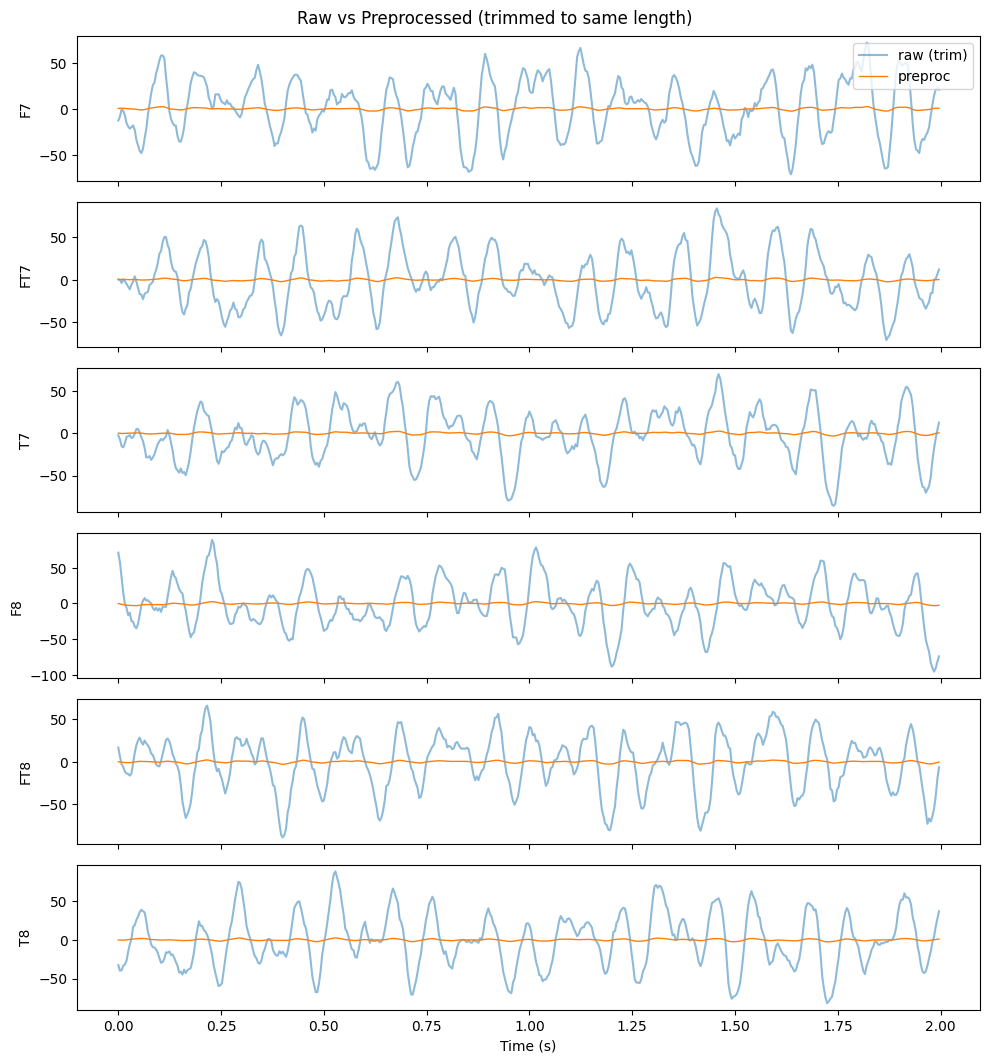

In [6]:
# Raw vs Preprocessed (trimmed overlay to match length)
import matplotlib.pyplot as plt
import numpy as np

ch_names = dataset.get('channel_names', [f'ch{i+1}' for i in range(n_channels)])
trial_idx = 0  # first trial
L_pre = X_time_train.shape[-1]        # length after windowing/preproc (e.g., 2s)
t_pre = np.arange(L_pre) / fs

fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 1.8*n_channels), sharex=True)
axes = np.atleast_1d(axes)

for c in range(n_channels):
    ax = axes[c]
    raw = dataset['X_train'][trial_idx, c]
    pre = X_time_train[trial_idx, c]
    raw_trim = raw[:L_pre]            # trim raw to the same length as pre
    ax.plot(t_pre, raw_trim, alpha=0.5, label='raw (trim)')
    ax.plot(t_pre, pre, lw=1.0, label='preproc')
    ax.set_ylabel(ch_names[c])

axes[0].legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
plt.suptitle('Raw vs Preprocessed (trimmed to same length)')
plt.tight_layout(); plt.show()

Ch F7 50Hz power raw=2.721e-01, pre=3.059e-07, reduction=100.0%


C:\Users\gansh\AppData\Local\Temp\ipykernel_106532\3180756454.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p50_raw = np.trapz(P_raw[m50], f_raw[m50])
C:\Users\gansh\AppData\Local\Temp\ipykernel_106532\3180756454.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p50_pre = np.trapz(P_pre[m50p], f_pre[m50p])


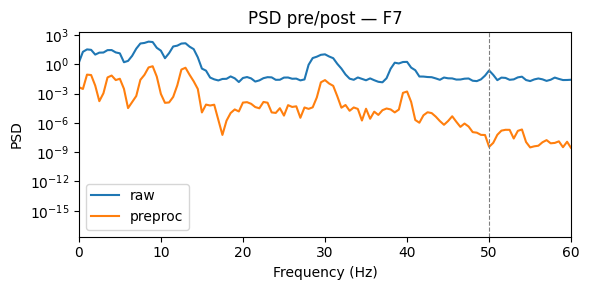

Ch F8 50Hz power raw=3.084e-01, pre=4.164e-07, reduction=100.0%


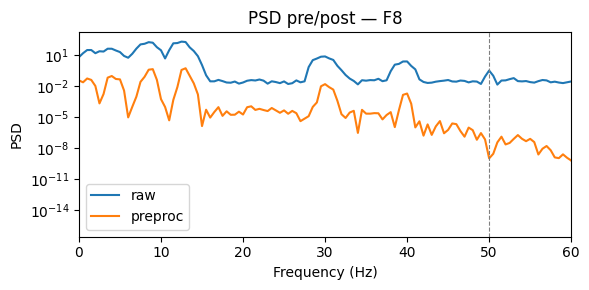

In [7]:
from scipy.signal import welch

def psd(x, fs, nperseg=None, noverlap=None):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling='density')
    return f, Pxx

trial_idx = 0
chan_list = [0, 3]  # e.g., F7/F8 if present
nper = int(fs*2.0); nov = int(fs*1.0)

for c in chan_list:
    f_raw, P_raw = psd(dataset['X_train'][trial_idx, c], fs, nper, nov)
    f_pre, P_pre = psd(X_time_train[trial_idx, c], fs, nper, nov)

    # 50 Hz band power ratio
    m50 = (f_raw >= 48) & (f_raw <= 52)
    p50_raw = np.trapz(P_raw[m50], f_raw[m50])
    m50p = (f_pre >= 48) & (f_pre <= 52)
    p50_pre = np.trapz(P_pre[m50p], f_pre[m50p])
    print(f'Ch {ch_names[c]} 50Hz power raw={p50_raw:.3e}, pre={p50_pre:.3e}, reduction={(1 - p50_pre/max(p50_raw,1e-12))*100:.1f}%')

    # plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.semilogy(f_raw, P_raw, label='raw')
    plt.semilogy(f_pre, P_pre, label='preproc')
    plt.axvline(50, ls='--', lw=0.8, color='grey')
    plt.xlim(0, 60); plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD')
    plt.title(f'PSD pre/post — {ch_names[c]}')
    plt.legend(); plt.tight_layout(); plt.show()


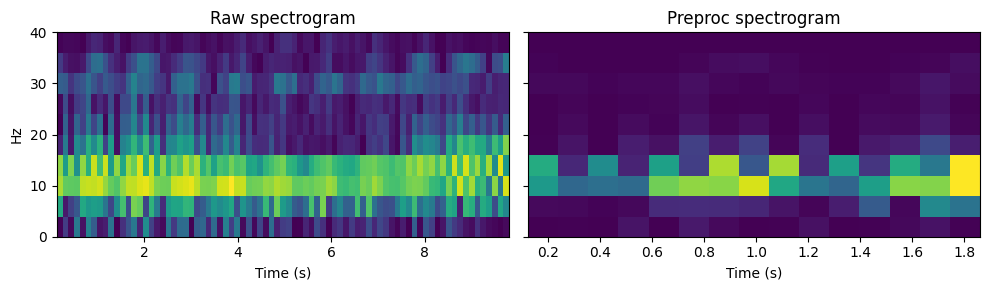

In [8]:
from scipy.signal import spectrogram

chan = 0
x0 = dataset['X_train'][trial_idx, chan]
x1 = X_time_train[trial_idx, chan]
f0, t0, S0 = spectrogram(x0, fs=fs, nperseg=int(fs*0.25), noverlap=int(fs*0.125), scaling='density', mode='psd')
f1, t1, S1 = spectrogram(x1, fs=fs, nperseg=int(fs*0.25), noverlap=int(fs*0.125), scaling='density', mode='psd')

def _norm_log(S):
    L = np.log1p(S)
    return (L - L.mean())/(L.std()+1e-8)

S0n = _norm_log(S0[f0<=40])
S1n = _norm_log(S1[f1<=40])

fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)
im0 = axes[0].imshow(S0n, aspect='auto', origin='lower', extent=[t0[0], t0[-1], 0, 40])
axes[0].set_title('Raw spectrogram'); axes[0].set_xlabel('Time (s)'); axes[0].set_ylabel('Hz')
im1 = axes[1].imshow(S1n, aspect='auto', origin='lower', extent=[t1[0], t1[-1], 0, 40])
axes[1].set_title('Preproc spectrogram'); axes[1].set_xlabel('Time (s)')
plt.tight_layout(); plt.show()


In [9]:
from utils.features import extract_features

BANDS = ((4,8),(8,13),(13,30))
features = extract_features(
    X_time_train, X_time_val, X_time_test, fs,
    bands=BANDS,
    welch_nperseg=int(fs*0.5), welch_noverlap=int(fs*0.25),
    make_images=True,
    spec_nperseg=int(fs*0.25), spec_noverlap=int(fs*0.125),
    fmax=40.0,
    channel_method='average'
)

for k in ['X_time_train','X_freq_train','X_img_train']:
    v = features[k]
    print(k, None if v is None else v.shape)


X_time_train (648, 6, 500)
X_freq_train (648, 6, 3)
X_img_train (648, 1, 10, 15)


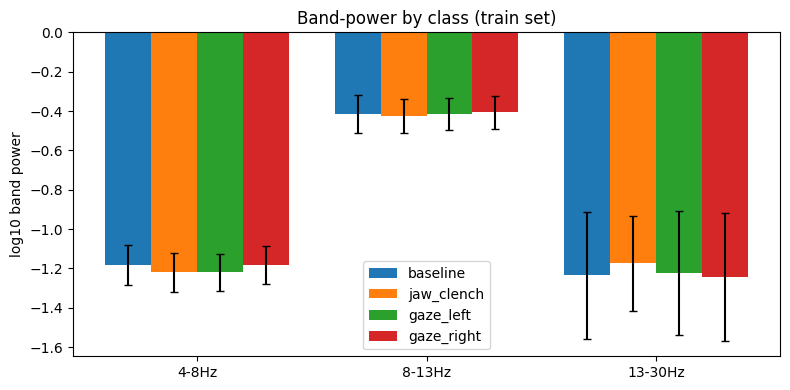

In [10]:
# reduce channel by mean; shape -> (N, B)
def collapse_channels(bp):  # bp: (N,C,B)
    return bp.mean(axis=1)

bp_train = collapse_channels(features['X_freq_train'])
y_train  = dataset['y_train'].astype(int)

bands_labels = [f'{lo}-{hi}Hz' for lo,hi in ((4,8),(8,13),(13,30))]

# per-class mean ± std
classes = np.unique(y_train)
means = []; stds = []
for cls in classes:
    x = bp_train[y_train==cls]  # (n_cls, B)
    means.append(x.mean(axis=0))
    stds.append(x.std(axis=0))
means = np.stack(means)  # (K,B)
stds  = np.stack(stds)

x = np.arange(len(bands_labels))
width = 0.8 / len(classes)

plt.figure(figsize=(8,4))
for i, cls in enumerate(classes):
    plt.bar(x + i*width, means[i], width=width, yerr=stds[i], capsize=3, label=str(class_names[cls]))
plt.xticks(x + width*(len(classes)-1)/2, bands_labels)
plt.ylabel('log10 band power')
plt.title('Band-power by class (train set)')
plt.legend()
plt.tight_layout(); plt.show()


C:\Users\gansh\AppData\Local\Temp\ipykernel_106532\3746028956.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(class_names[c]) for c in classes], showmeans=True)


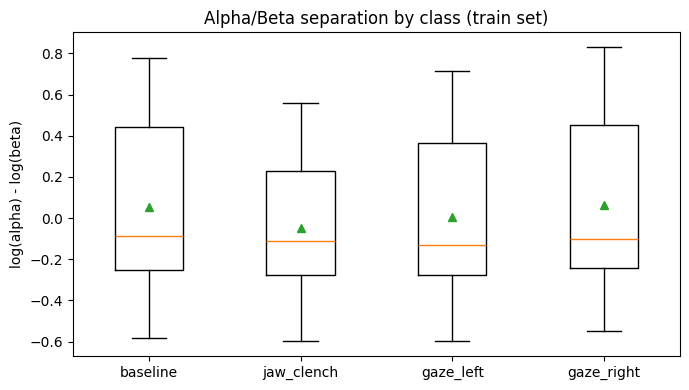

In [11]:
# compute alpha/beta ratio on train
alpha_idx = 0  # 4-8
beta_idx  = 2  # 13-30
bp = collapse_channels(features['X_freq_train'])  # (N,B)
ratio = bp[:, alpha_idx] - bp[:, beta_idx]  # log domain difference approximates log(alpha/beta)

data = [ratio[y_train==cls] for cls in classes]

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=[str(class_names[c]) for c in classes], showmeans=True)
plt.ylabel('log(alpha) - log(beta)')
plt.title('Alpha/Beta separation by class (train set)')
plt.tight_layout(); plt.show()


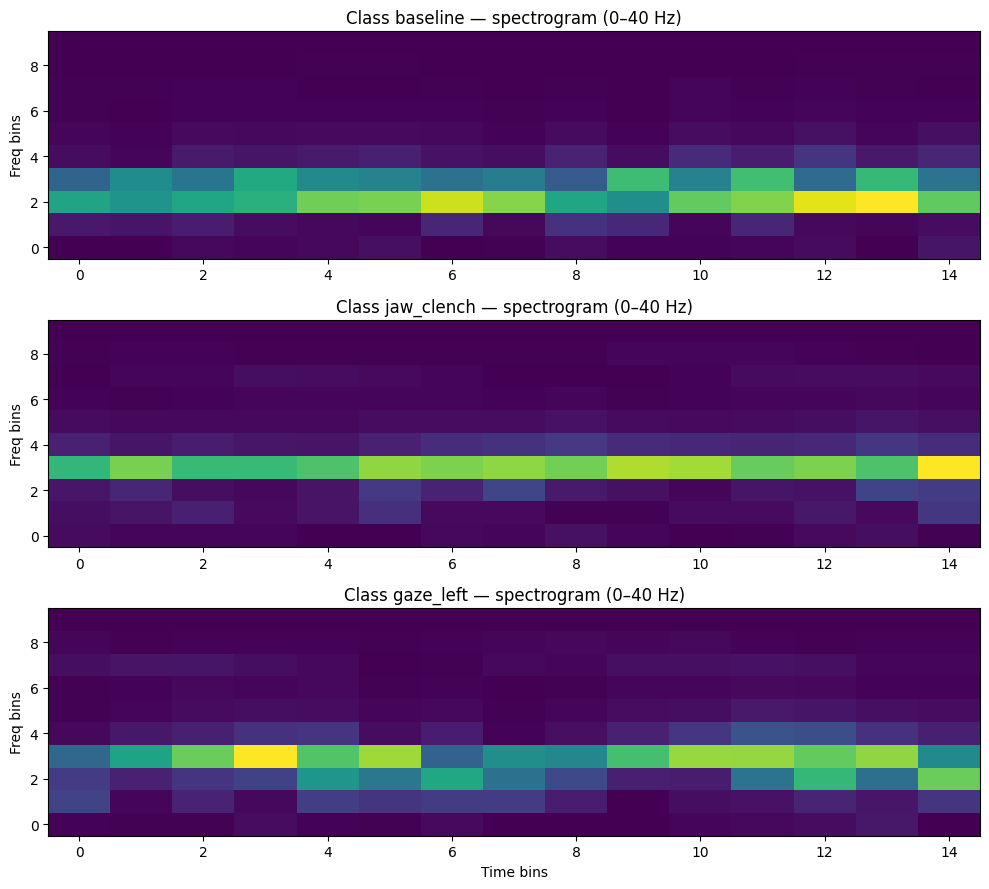

In [12]:
Ximg = features['X_img_train']  # (N,1,H,W) or None
if Ximg is not None:
    shown = 0
    plt.figure(figsize=(10, 3*min(len(classes),3)))
    for i, cls in enumerate(classes[:3]):  # up to 3 classes
        idx = np.where(y_train==cls)[0][0]
        img = Ximg[idx,0]
        ax = plt.subplot(min(len(classes),3), 1, i+1)
        ax.imshow(img, aspect='auto', origin='lower')
        ax.set_title(f'Class {class_names[cls]} — spectrogram (0–40 Hz)')
        ax.set_ylabel('Freq bins')
    plt.xlabel('Time bins')
    plt.tight_layout(); plt.show()
else:
    print('No image branch features.')


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGMultimodalDataset(Dataset):
    def __init__(self, feats, split, labels_dict):
        self.X_time = feats[f'X_time_{split}']     # (N,C,T)
        self.X_freq = feats[f'X_freq_{split}']     # (N,C,B)
        self.X_img  = feats[f'X_img_{split}']      # (N,1,H,W) or None
        self.y      = labels_dict[f'y_{split}'].astype(int)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        s = {
            'time': torch.tensor(self.X_time[idx], dtype=torch.float32),
            'freq': torch.tensor(self.X_freq[idx], dtype=torch.float32),
            'label': torch.tensor(int(self.y[idx]), dtype=torch.long)
        }
        if self.X_img is not None:
            s['img'] = torch.tensor(self.X_img[idx], dtype=torch.float32)
        return s

train_loader = DataLoader(EEGMultimodalDataset(features, 'train', dataset), batch_size=Config.batch_size, shuffle=True,  num_workers=Config.num_workers)
val_loader   = DataLoader(EEGMultimodalDataset(features, 'val',   dataset), batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
test_loader  = DataLoader(EEGMultimodalDataset(features, 'test',  dataset), batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)


In [14]:
import torch.nn as nn, torch.optim as optim
from models.multimodal_model import MultiModalNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

use_img = features['X_img_train'] is not None
n_bands = features['X_freq_train'].shape[2]

model = MultiModalNet(
    n_channels = int(features['X_time_train'].shape[1]),
    n_samples  = int(features['X_time_train'].shape[2]),
    n_bands    = int(n_bands),
    img_out_dim= Config.img_out_dim,
    hidden_dim = Config.hidden_dim,
    n_classes  = int(len(class_names)),
    use_img    = use_img
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)

# remove verbose for compatibility
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)

def get_lr(opt):
    # single param group assumed
    return opt.param_groups[0]['lr']

print('torch:', torch.__version__)
print('Device:', device, '| params:', sum(p.numel() for p in model.parameters()))
print('Init LR:', get_lr(optimizer))


torch: 2.7.1+cu118
Device: cuda | params: 11270724
Init LR: 0.001


In [15]:
def run_epoch(loader, train=True):
    model.train(mode=train)
    total, correct, loss_sum = 0, 0, 0.0
    for b in loader:
        if train: optimizer.zero_grad()
        t = b['time'].to(device)
        f = b['freq'].to(device)
        i = b.get('img'); i = i.to(device) if (use_img and i is not None) else None
        y = b['label'].to(device)
        out = model(t, f, i)
        loss = criterion(out, y)
        if train:
            loss.backward(); optimizer.step()
        loss_sum += loss.item()
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)
    return loss_sum/len(loader), 100.0*correct/max(1,total)

best_val, wait = 0.0, 0
hist = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}

for epoch in range(1, Config.num_epochs+1):
    tl, ta = run_epoch(train_loader, True)
    vl, va = run_epoch(val_loader, False)

    # track LR change
    prev_lr = get_lr(optimizer)
    scheduler.step(va)
    new_lr = get_lr(optimizer)
    lr_msg = f' | lr {prev_lr:.2e}->{new_lr:.2e}' if new_lr < prev_lr else ''

    hist['train_loss'].append(tl); hist['val_loss'].append(vl)
    hist['train_acc'].append(ta);  hist['val_acc'].append(va)
    print(f'E{epoch:02d} | train {ta:5.1f}%/{tl:.4f}  val {va:5.1f}%/{vl:.4f}{lr_msg}')

    if va > best_val:
        best_val, wait = va, 0
        torch.save(model.state_dict(), 'best_multimodal.pt')
    else:
        wait += 1
        if wait >= Config.patience:
            print('Early stop.')
            break


E01 | train  39.2%/1.2909  val  10.4%/2.1595
E02 | train  52.5%/1.1245  val   9.7%/2.1175
E03 | train  63.9%/0.9552  val  11.8%/2.6067
E04 | train  67.3%/0.8541  val  34.0%/2.1636
E05 | train  82.9%/0.5294  val  29.2%/2.3274
E06 | train  88.7%/0.3313  val  27.8%/3.0185
E07 | train  91.5%/0.2519  val  22.9%/3.7900
E08 | train  88.7%/0.3483  val  10.4%/5.0050 | lr 1.00e-03->5.00e-04
E09 | train  90.6%/0.3327  val  13.9%/3.6177
E10 | train  96.8%/0.1266  val  25.0%/3.8035
E11 | train  97.1%/0.1058  val  18.1%/4.1729
E12 | train  98.9%/0.0531  val  23.6%/4.6908 | lr 5.00e-04->2.50e-04
E13 | train  99.1%/0.0353  val  20.8%/4.8351
E14 | train  99.2%/0.0301  val  18.8%/4.8881
Early stop.


              precision    recall  f1-score   support

    baseline     0.3125    0.1852    0.2326        27
  jaw_clench     0.2000    0.4074    0.2683        27
   gaze_left     0.1538    0.1481    0.1509        27
  gaze_right     0.0909    0.0370    0.0526        27

    accuracy                         0.1944       108
   macro avg     0.1893    0.1944    0.1761       108
weighted avg     0.1893    0.1944    0.1761       108



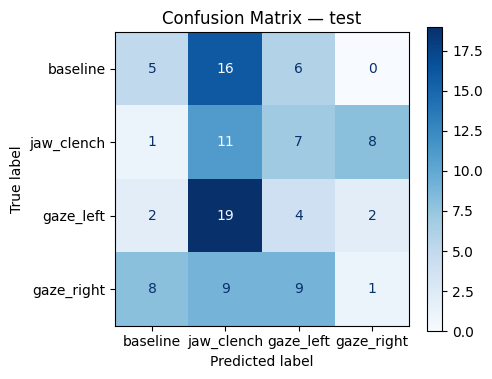

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

model.load_state_dict(torch.load('best_multimodal.pt', map_location=device))
model.eval()

y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for b in test_loader:
        t = b['time'].to(device); f = b['freq'].to(device)
        i = b.get('img'); i = i.to(device) if (use_img and i is not None) else None
        y = b['label'].to(device)
        logits = model(t, f, i)
        prob = torch.softmax(logits, dim=1)
        pred = prob.argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
        y_prob.append(prob.cpu().numpy())
y_true = np.array(y_true); y_pred = np.array(y_pred)
y_prob = np.concatenate(y_prob, axis=0)

print(classification_report(y_true, y_pred, target_names=[str(c) for c in class_names], digits=4))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=[str(c) for c in class_names], cmap='Blues', ax=ax)
plt.title('Confusion Matrix — test')
plt.tight_layout(); plt.show()


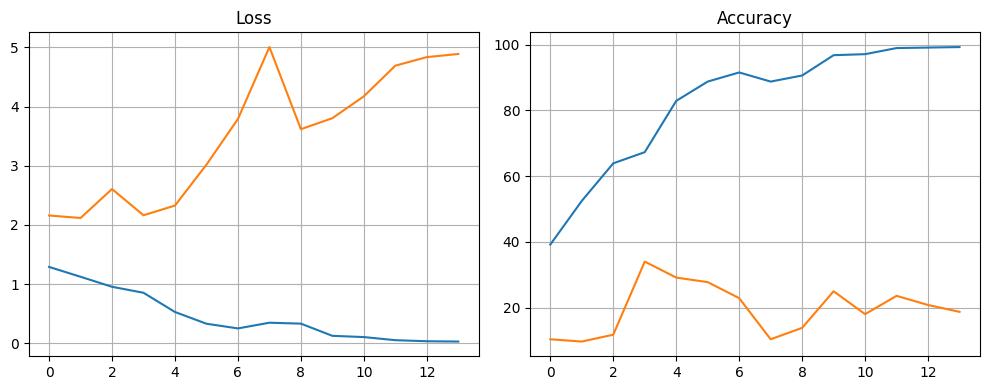

macro-ROC-AUC (OvR): 0.4921


In [17]:
# curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist['train_loss']); plt.plot(hist['val_loss']); plt.title('Loss'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist['train_acc']);  plt.plot(hist['val_acc']);  plt.title('Accuracy'); plt.grid(True)
plt.tight_layout(); plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
if len(class_names) > 2:
    y_onehot = label_binarize(y_true, classes=sorted(np.unique(y_true)))
    try:
        auc_macro = roc_auc_score(y_onehot, y_prob, average='macro', multi_class='ovr')
        print('macro-ROC-AUC (OvR):', round(auc_macro,4))
    except Exception as e:
        print('AUC not available:', e)


Val accuracy: 0.3403
Val F1-macro: 0.3064
              precision    recall  f1-score   support

    baseline     0.2174    0.1389    0.1695        36
  jaw_clench     0.3059    0.7222    0.4298        36
   gaze_left     0.7727    0.4722    0.5862        36
  gaze_right     0.0714    0.0278    0.0400        36

    accuracy                         0.3403       144
   macro avg     0.3419    0.3403    0.3064       144
weighted avg     0.3419    0.3403    0.3064       144



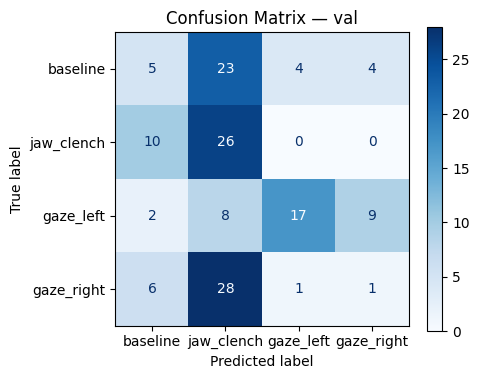

Val macro-ROC-AUC (OvR): 0.5366


In [18]:
# Validate with saved checkpoint
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# ensure best ckpt exists
import os
if not os.path.exists('best_multimodal.pt'):
    torch.save(model.state_dict(), 'best_multimodal.pt')

# load and eval on val
model.load_state_dict(torch.load('best_multimodal.pt', map_location=device))
model.eval()

y_true_v, y_pred_v, y_prob_v = [], [], []
with torch.no_grad():
    for b in val_loader:
        t = b['time'].to(device)
        f = b['freq'].to(device)
        i = b.get('img'); i = i.to(device) if (use_img and i is not None) else None
        y = b['label'].to(device)

        logits = model(t, f, i)
        prob = torch.softmax(logits, dim=1)
        pred = prob.argmax(1)

        y_true_v.extend(y.cpu().numpy())
        y_pred_v.extend(pred.cpu().numpy())
        y_prob_v.append(prob.cpu().numpy())

y_true_v = np.array(y_true_v)
y_pred_v = np.array(y_pred_v)
y_prob_v = np.concatenate(y_prob_v, axis=0)

print('Val accuracy:', round(accuracy_score(y_true_v, y_pred_v), 4))
print('Val F1-macro:', round(f1_score(y_true_v, y_pred_v, average="macro"), 4))
print(classification_report(y_true_v, y_pred_v, target_names=[str(c) for c in class_names], digits=4))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_true_v, y_pred_v,
    display_labels=[str(c) for c in class_names],
    cmap='Blues', ax=ax
)
plt.title('Confusion Matrix — val')
plt.tight_layout(); plt.show()

# optional ROC-AUC (multi-class)
if len(class_names) > 2:
    try:
        y_onehot_v = label_binarize(y_true_v, classes=sorted(np.unique(y_true_v)))
        auc_macro_v = roc_auc_score(y_onehot_v, y_prob_v, average='macro', multi_class='ovr')
        print('Val macro-ROC-AUC (OvR):', round(auc_macro_v, 4))
    except Exception as e:
        print('Val AUC not available:', e)
